In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
import nd2
import cmocean
import toml

from markovids.depth.moments import im_moment_features
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

In [3]:
config = toml.load("../preprocessing/config.toml")

In [4]:
# directory pointing to nd2 files
data_dir = os.path.join(config["dirs"]["data"], "histology_epifluorescence/")
data_files = sorted(glob.glob(os.path.join(data_dir, "*.nd2")))
data_files = [_file for _file in data_files if "BF" not in _file]

In [5]:
# where you want figures to be stored
fig_dir = config["dirs"]["figs"]
os.makedirs(fig_dir, exist_ok=True)

## User functions

In [6]:
def get_rotation_angle_moments(use_im, threshold=None, decimate=2):
    if threshold is None:
        threshold = np.percentile(use_im[use_im > 0], 97.5)
    contours, hierarchy = cv2.findContours(
        (use_im > threshold).astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    areas = [cv2.contourArea(_cnt) for _cnt in contours]
    largest_contour = np.argmax(areas)
    features = im_moment_features(contours[largest_contour])
    return np.rad2deg(features["orientation"]), features["centroid"]


def get_rotated_and_centered_image(
    use_im,
    bbox_size=(2500, 6000),
    peak_threshold=None,
    peak_crop=True,
    peak_smooth=(10, 10),
    angle_only=True,
    **kwargs
):
    h, w = use_im.shape

    if peak_crop:
        if peak_threshold is None:
            threshold = np.percentile(use_im[use_im > 0], 95)

        contours, hierarchy = cv2.findContours(
            (use_im > threshold).astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        areas = [cv2.contourArea(_cnt) for _cnt in contours]
        largest_contour = np.argmax(areas)
        features = im_moment_features(contours[largest_contour])
        px, py = features["centroid"]
        py = np.round(py).astype("int")
        px = np.round(px).astype("int")

        bbox_w = bbox_size[0] // 2
        bbox_h = bbox_size[1] // 2
        bottom = np.maximum(py - bbox_h, 0)
        top = np.minimum(py + bbox_h, h)
        left = np.maximum(px - bbox_w, 0)
        right = np.minimum(px + bbox_w, w)
        use_im = use_im[bottom:top, left:right]

    h, w = use_im.shape

    rotate_angle, (cx, cy) = get_rotation_angle_moments(use_im)
    M_rotate = cv2.getRotationMatrix2D((cx, cy), 90 - rotate_angle, 1.0)
    M_rotate = np.append(M_rotate, [[0, 0, 1]], axis=0)

    if angle_only:
        M_warp = M_rotate
    else:
        ty = -(cy - h // 2)
        tx = -(cx - w // 2)
        M_translate = np.array([[1.0, 0.0, tx], [0.0, 1.0, ty], [0.0, 0.0, 1]])
        M_warp = M_rotate @ M_translate
    rotated = cv2.warpAffine(use_im, M_warp[:2, :], (w, h), borderValue=use_im[:, :100].mean())
    return rotated, M_warp, use_im

In [7]:
def compute_fwhm(x, y):
    y = y - np.min(y)  # remove baseline
    half_max = np.max(y) / 2.0

    # Find indices where y crosses half max
    above = y > half_max
    if not np.any(above):
        return 0

    # Find rising and falling edge
    indices = np.where(np.diff(above.astype(int)) != 0)[0]

    if len(indices) < 2:
        return 0  # Not enough crossings to compute FWHM

    # Interpolate left and right crossing points
    i1, i2 = indices[0], indices[-1]
    f_left = interp1d(y[i1 : i1 + 2], x[i1 : i1 + 2])
    f_right = interp1d(y[i2 : i2 + 2], x[i2 : i2 + 2])
    x_left = f_left(half_max)
    x_right = f_right(half_max)

    return x_right - x_left

## Process and plot data

In [8]:
store_dat = {}
for _file in tqdm(data_files):
    key = os.path.basename(_file)
    with nd2.ND2File(_file) as f:
        im = f.asarray()
        metadata = f.metadata
        voxel_size = f.voxel_size()  # in microns... gives microns per pixel in x, y, and z

    rotated, M_warp, crop_im = get_rotated_and_centered_image(im)
    rotated = rotated.astype("float32")
    store_dat[key] = {}
    store_dat[key]["rotated_im"] = rotated
    store_dat[key]["y_profile"] = np.nanmean(rotated, axis=1)
    store_dat[key]["x_profile"] = np.nanmean(rotated, axis=0)
    store_dat[key]["x_voxel_size"] = voxel_size.x
    store_dat[key]["y_voxel_size"] = voxel_size.y

  0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
epidermis_side = {
    "QD_perfusion_01_back_C_01_Cy7_10X.nd2": "l",
    "QD_perfusion_01_back_C_10X.nd2": "l",
    "QD_perfusion_01_back_V_10X.nd2": "r",
    "QD_perfusion_02_back_C_01_10X.nd2": "l",
    "QD_perfusion_02_back_C_10X.nd2": "l",
    "QD_perfusion_02_back_V_anterior_10X.nd2": "l",
    "QD_perfusion_02_back_V_posterior_10X.nd2": "l"
}

In [10]:
from qd_analysis.fig import setup_plotting_env
setup_plotting_env()

In [11]:
cmap = "inferno"

In [12]:
cmap = cmocean.cm.thermal.copy()
cmap.set_bad([0, 0, 0, 1])

/tmp/ipykernel_152594/2365793260.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


QD_perfusion_01_back_C_01_Cy7_10X.nd2
QD_perfusion_01_back_C_10X.nd2
QD_perfusion_01_back_V_10X.nd2
QD_perfusion_02_back_C_01_10X.nd2
QD_perfusion_02_back_C_10X.nd2
QD_perfusion_02_back_V_anterior_10X.nd2
QD_perfusion_02_back_V_posterior_10X.nd2


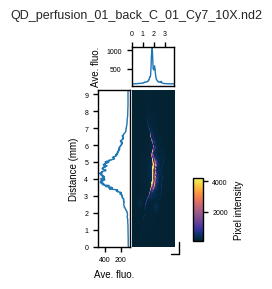

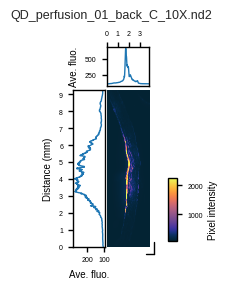

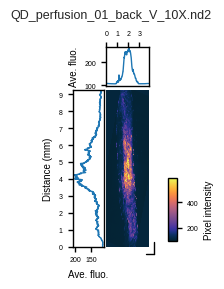

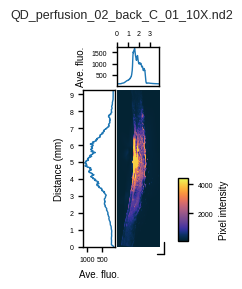

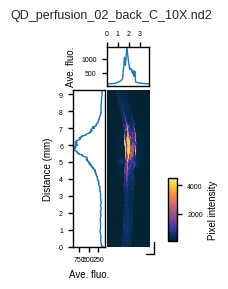

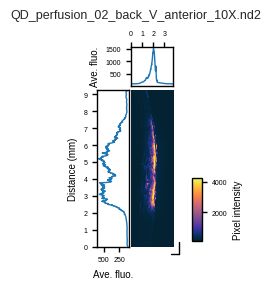

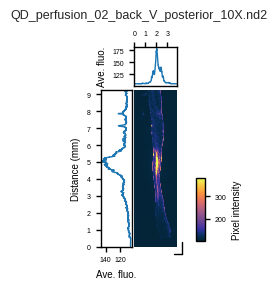

In [13]:
for k, v in store_dat.items():
    rotated = v["rotated_im"].copy()

    if epidermis_side[k] == "l":
        rotated = cv2.rotate(rotated, cv2.ROTATE_180)

    x_profile = rotated.mean(axis=0)
    y_profile = rotated.mean(axis=1)
    store_dat[k]["x_profile"] = x_profile
    store_dat[k]["y_profile"] = y_profile

    h, w = rotated.shape
    clims = np.nanpercentile(rotated, 5), np.nanpercentile(rotated, 99.5)
    clims = (clims[0], clims[1] * 1.1)
    # https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
    fig = plt.figure(figsize=(0.95, 2.5))
    gs = fig.add_gridspec(
        2,
        2,
        height_ratios=(1, 4),
        width_ratios=(0.75, 1),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.05,
        hspace=0.05,
    )
    # Create the Axes.
    xvec = (np.arange(rotated.shape[1]) / voxel_size.x) / 1e3
    yvec = (np.arange(rotated.shape[0]) / voxel_size.y) / 1e3

    ax = fig.add_subplot(gs[1, 1])
    ax_histx = fig.add_subplot(gs[0, 1])
    ax_histx.plot(xvec, x_profile)
    # ax_histx.set_xlabel("Distance (µm)")
    ax_histx.set_ylabel("Ave. fluo.")
    ax_histx.set_xticks(np.arange(0, 4))
    ax_histx.set_xlim(0, xvec[-1])
    ax_histx.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    ax_histy = fig.add_subplot(gs[1, 0])
    ax_histy.plot(y_profile, yvec)
    ax_histy.set_ylabel("Distance (mm)")
    ax_histy.set_xlabel("Ave. fluo.")
    ax_histy.set_yticks(np.arange(0, 12))
    # ax_histy.set_xlim(100, 300)
    ax_histy.invert_xaxis()
    ax_histy.set_ylim(0, yvec[-1])

    h_im = ax.imshow(rotated[::-1], cmap=cmap, vmin=clims[0], vmax=clims[1], aspect="auto")

    # add scale bar, burn in image?

    x_anchor = w + 300
    y_anchor = h + 300

    scale_bar_width = 300 / voxel_size.x
    scale_bar_height = 300 / voxel_size.y

    scalex = plt.Line2D(
        [x_anchor - scale_bar_width, x_anchor], [y_anchor] * 2, lw=1.0, color="k", alpha=1.0, clip_on=False
    )
    scaley = plt.Line2D(
        [x_anchor] * 2, [y_anchor - scale_bar_height, y_anchor], lw=1.0, color="k", alpha=1.0, clip_on=False
    )
    ax.add_line(scalex)
    ax.add_line(scaley)
    fig.suptitle(k, fontsize=9, y=1.05)
    fig.tight_layout()

    cb_ax = fig.add_axes([1.1, 0.124, 0.1, 0.25])
    fig.colorbar(h_im, cax=cb_ax, orientation="vertical", label="Pixel intensity")
    print(k)

    ax.axis("off")
    fig.savefig(os.path.join(fig_dir, f"{k}.pdf"), bbox_inches="tight", dpi=600)
    # scale bar

In [14]:
saturation_value = 4095
for k, v in store_dat.items():
    sat_values = (v["rotated_im"] >= saturation_value).sum()
    store_dat[k]["saturated_values"] = sat_values

    for direction in ["x", "y"]:
        use_profile = v[f"{direction}_profile"]
        xvec = np.arange(len(use_profile))
        xvec = xvec / v[f"{direction}_voxel_size"]
        xvec /= 1e3
        fwhm = compute_fwhm(xvec, use_profile)
        store_dat[k][f"{direction}_fwhm"] = fwhm

In [15]:
store_dat_unsaturated = {k: v for k, v in store_dat.items() if v["saturated_values"] == 0}

In [16]:
clip_length = 1

In [17]:
# HERE remove saturated ims...

In [18]:
use_unsaturated = True
if use_unsaturated:
    use_dat = store_dat_unsaturated
else:
    use_dat = store_dat

In [19]:
all_keys = list(use_dat.keys())

In [20]:
cell_keys = sorted([_key for _key in all_keys if "_C_" in _key])
vascular_keys = sorted([_key for _key in all_keys if "_V_" in _key])


In [21]:
vascular_pal = sns.color_palette("light:blue", n_colors=len(vascular_keys)+1)[1:]
cell_pal = sns.color_palette("light:orange", n_colors=len(cell_keys)+1)[1:]

In [22]:
pal = vascular_pal + cell_pal

In [23]:
new_order = vascular_keys + cell_keys
use_dat = {k: use_dat[k] for k in new_order}

In [24]:
align = "peak"
direction = "y"

In [25]:
all_x_profiles = [v["x_profile"] for v in use_dat.values()]
all_y_profiles = [v["y_profile"] for v in use_dat.values()]

In [26]:
setup_plotting_env()

(-4, 4)


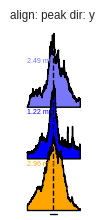

In [27]:
fig, ax = plt.subplots(len(all_x_profiles), 1, figsize=(0.75, 2.3), sharex=True, sharey=True)

if direction == "x" and align == "peak":
    clip_limits = (-1.5, 1.5)
elif direction == "x" and align == "crossing":
    clip_limits = (-2, 0.5)
elif direction == "y" and align == "peak":
    clip_limits = (-4, 4)
elif direction == "y" and align == "crossing":
    clip_limits = (-0.5, 7)

print(clip_limits)
for _ax, (_key, _value), _color in zip(ax, use_dat.items(), pal):
    # prof here
    _profile = _value[f"{direction}_profile"]
    fwhm = _value[f"{direction}_fwhm"]
    maxmin = (_profile - min(_profile)) / (max(_profile) - min(_profile))
    zprofile = (_profile - _profile.mean()) / _profile.std()
    # com = center_of_mass(_profile)
    if align == "peak":
        align_point = _profile.argmax()
    elif align == "crossing":
        align_point = max(np.flatnonzero(zprofile > 0))

    xvec = np.arange(len(maxmin)) - align_point
    xvec = xvec / _value[f"{direction}_voxel_size"]
    xvec /= 1e3

    clip = min(np.flatnonzero(xvec >= clip_limits[0])), max(np.flatnonzero(xvec <= clip_limits[1]))

    # also align to threshold crossing to get edge of tissue.
    _ax.fill_between(
        xvec[clip[0] : clip[1]], maxmin[clip[0] : clip[1]], alpha=1, lw=1, ec="k", clip_on=False, fc=_color
    )
    _ax.text(xvec[clip[0]], 0.6, f"{fwhm:0.2f} mm", color=_color, fontsize=5)

for _ax in ax:
    _ax.set_yticks([])
    _ax.set_clip_on(False)
    _ax.set_xticks([])
    _ax.axis("off")
    _ax.set_ylim([0, 1])

# add scale bar here
ax[-1].plot([0, 0], [0, len(all_x_profiles) * 0.75], clip_on=False, color="k", ls="--")
ax[-1].plot([-0.5, 0.5], [-0.05, -0.05], color="k", clip_on=False)
fig.subplots_adjust(hspace=-0.3)
fig.suptitle(f"align: {align} dir: {direction}")
# fig.tight_layout()
fig.savefig(
    os.path.join(
        fig_dir, f"histology_density_align-{align}_direction-{direction}_scale-1mm_unsaturated-{use_unsaturated}.pdf"
    ),
    bbox_inches="tight",
)